## Clone the Repository

In [1]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

Cloning into 'fastercnn-pytorch-training-pipeline'...
remote: Enumerating objects: 1241, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 1241 (delta 258), reused 253 (delta 241), pack-reused 904
Receiving objects: 100% (1241/1241), 10.57 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (840/840), done.


We will execute all the code within the cloned project directory, that is `fastercnn-pytorch-training-pipeline`.

In [2]:
import torch
torch.__version__

'2.0.0'

In [3]:
# Enter the repo directory.
%cd fastercnn-pytorch-training-pipeline/

/kaggle/working/fastercnn-pytorch-training-pipeline


In [4]:
%%writefile requirements.txt
# Base-------------------------------------
albumentations>=1.1.0
ipython
jupyter
matplotlib
opencv-python>=4.1.1.26
opencv-python-headless>=4.1.1.26
Pillow
PyYAML
scikit-image
scikit-learn
scipy
# torch==2.0.0
# torchvision==0.15.1
numpy
protobuf<=3.20.1
pandas
tqdm

# Logging----------------------------------
wandb
tensorboard

# Model summary----------------------------
torchinfo

# Extras-----------------------------------
pycocotools>=2.0.2
setuptools==59.5.0
torchmetrics # Evaluation

# Transformer based models.
vision_transformers

# Export-----------------------------------
# onnxruntime
# onnx
# onnxruntime-gpu

Overwriting requirements.txt


In [5]:
# Install the Requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=93593 sha256=059cb6a92f3ba219d347cdf1f6a63ab5cf0220110690de478fbbea62160df154
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
  Created wheel for vision_transformers: filename=vision_transformers-0.1.1.0-py3-none-any.whl size=48431 sha256=35defbf9f9479029315edace83454d8d679bde1dcc2855cb6acabc484ebb77be
  Stored in directory: /root/.cache/pip/wheels/02/f4/94/0a5c8d2a4fcb6aa4c590906ffd3d52dc8edbe94262ecaa7dae
Successfully built pycocotools vision_transformers
  Attempting uninstall: setuptools
    F

## Download the Dataset

Here we are using the [Aquarium Dataset](https://public.roboflow.com/object-detection/aquarium) from Roboflow.

Download the unzip the dataset to `custom_data` directory.

In [6]:
!curl -L "https://public.roboflow.com/ds/CNyGy97q45?key=eSpwiC1Ah7" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   3890      0 --:--:-- --:--:-- --:--:--  3907
100 68.0M  100 68.0M    0     0   100M      0 --:--:-- --:--:-- --:--:--  207M
Archive:  roboflow.zip
 extracting: custom_data/README.dataset.txt  
 extracting: custom_data/README.roboflow.txt  
   creating: custom_data/test/
 extracting: custom_data/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
 extracting: custom_data/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.xml  
 extracting: custom_data/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
 extracting: custom_data/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.xml  
 extracting: custom_data/test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  


## Create the Custom Dataset YAML File

The YAML file should contain:
* `TRAIN_DIR_IMAGES`: Path to the training images directory.
* `TRAIN_DIR_LABELS`: Path to the training labels directory containing the XML files. Can be the same as `TRAIN_DIR_IMAGES`.
* `VALID_DIR_IMAGES`: Path to the validation images directory.
* `VALID_DIR_LABELS`: Path to the validation labels directory containing the XML files. Can be the same as `VALID_DIR_IMAGES`.
* `CLASSES`: All the class names in the dataset along with the `__background__` class as the first class.
* `NC`: The number of classes. This should be the number of classes in the dataset + the background class. If the number of classes in the dataset are 7, then `NC` should be 8.
* `SAVE_VALID_PREDICTION_IMAGES`: Whether to save the prediction results from the validation loop or not.

In [7]:
%%writefile data_configs/custom_data.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: 'custom_data/train'
TRAIN_DIR_LABELS: 'custom_data/train'
VALID_DIR_IMAGES: 'custom_data/valid'
VALID_DIR_LABELS: 'custom_data/valid'

# Class names.
CLASSES: [
    '__background__',
    'fish', 'jellyfish', 'penguin', 
    'shark', 'puffin', 'stingray',
    'starfish'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 8

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Writing data_configs/custom_data.yaml


## Training

For this training example we use:
* The official Faster RCNN ResNet50 FPN model.
* Batch size of 8. You may change it according to the GPU memory available.

In [8]:
!wandb disabled

W&B disabled.


In [9]:
# Train the Aquarium dataset for 30 epochs.
!python train.py --data data_configs/custom_data.yaml --epochs 5 --model fasterrcnn_resnet50_fpn_v2 --name custom_training --batch 8

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Visualize Validation Results

Check out a few validation results from `outputs/training/custom_training` directory.

In [10]:
import matplotlib.pyplot as plt
import glob as glob

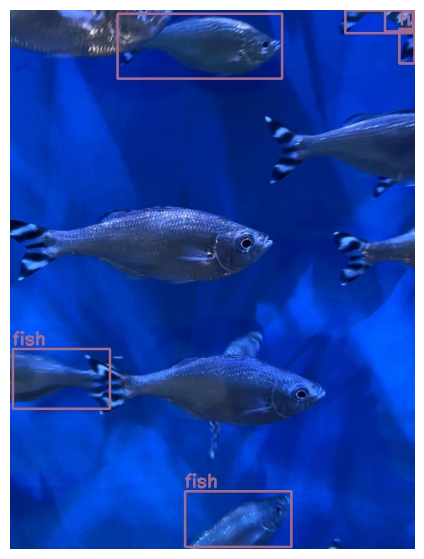

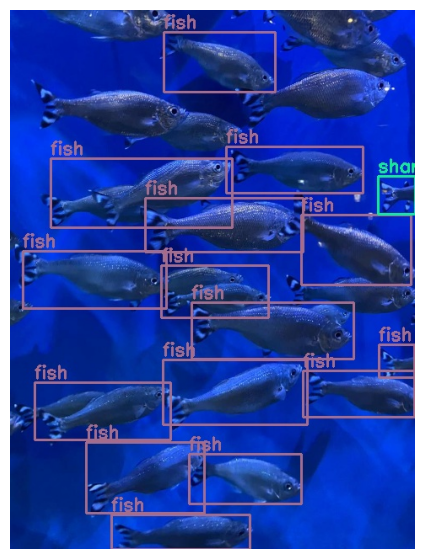

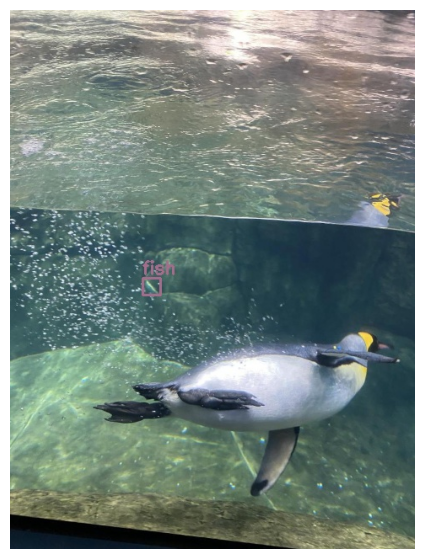

In [11]:
results_dir_path = 'outputs/training/custom_training'
valid_images = glob.glob(f"{results_dir_path}/*.jpg")

for i in range(3):
    plt.figure(figsize=(10, 7))
    image = plt.imread(valid_images[i])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Check Out the Repo for Latest Updates

https://github.com/sovit-123/fastercnn-pytorch-training-pipeline

## Evaluation

In [12]:
# No verbose mAP.
!python eval.py --weights outputs/training/custom_training/best_model.pth --data data_configs/custom_data.yaml --model fasterrcnn_resnet50_fpn_v2

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [13]:
# Verbose mAP.
!python eval.py --weights outputs/training/custom_training/best_model.pth --data data_configs/custom_data.yaml --model fasterrcnn_resnet50_fpn_v2 --verbose

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso